In [ ]:
#AllenNLP Library
!pip install  -U allennlp_models 

In [17]:
!pip install pretty-confusion-matrix
!python -m pip uninstall matplotlib
!pip install matplotlib==3.1.3

ERROR: Operation cancelled by user
Traceback (most recent call last):
  File "/usr/local/lib/python3.8/dist-packages/pip/_internal/cli/base_command.py", line 180, in _main
    status = self.run(options, args)
  File "/usr/local/lib/python3.8/dist-packages/pip/_internal/commands/uninstall.py", line 85, in run
    uninstall_pathset = req.uninstall(
  File "/usr/local/lib/python3.8/dist-packages/pip/_internal/req/req_install.py", line 658, in uninstall
    uninstalled_pathset.remove(auto_confirm, verbose)
  File "/usr/local/lib/python3.8/dist-packages/pip/_internal/req/req_uninstall.py", line 380, in remove
    if auto_confirm or self._allowed_to_proceed(verbose):
  File "/usr/local/lib/python3.8/dist-packages/pip/_internal/req/req_uninstall.py", line 423, in _allowed_to_proceed
    return ask('Proceed (y/n)? ', ('y', 'n')) == 'y'
  File "/usr/local/lib/python3.8/dist-packages/pip/_internal/utils/misc.py", line 203, in ask
    response = input(message)
KeyboardInterrupt

During handling o

In [15]:
!pip install pretty_confusion_matrix
from allennlp_models.pretrained import load_predictor
import numpy as np
import pandas as pd 
from sklearn.preprocessing import LabelEncoder
from keras.utils import np_utils
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn import tree
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, precision_recall_fscore_support, balanced_accuracy_score \
                            ,matthews_corrcoef, average_precision_score, precision_recall_curve, auc, plot_precision_recall_curve
from pretty_confusion_matrix import pp_matrix_from_data
from sklearn.metrics import classification_report, f1_score, accuracy_score, confusion_matrix

In [4]:
#Model
model = load_predictor("pair-classification-roberta-snli")

#Exemple 
premise = "Two women are wandering along the shore drinking iced tea."
hypothesis = "Two women are sitting on a blanket near some rocks talking about politics."
preds = model.predict(premise,hypothesis)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


Output()

Downloading:   0%|          | 0.00/482 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/878k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/446k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.29M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.33G [00:00<?, ?B/s]

Some weights of the model checkpoint at roberta-large were not used when initializing RobertaModel: ['lm_head.dense.weight', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.decoder.weight', 'lm_head.dense.bias', 'lm_head.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Dataset for testing 

In [5]:
# downloading the dataset from the url
!wget https://nlp.stanford.edu/projects/snli/snli_1.0.zip
#unzip the files
!unzip snli_1.0.zip

# importing the dataset into dataframes
df_train = pd.read_csv("snli_1.0/snli_1.0_train.txt", sep="\t")
df_dev = pd.read_csv("snli_1.0/snli_1.0_dev.txt", sep="\t")
df_test = pd.read_csv("snli_1.0/snli_1.0_test.txt", sep="\t")

# extracting the required columns form the dataset
df_train = df_train[['gold_label','sentence1','sentence2']]
df_dev = df_dev[['gold_label','sentence1','sentence2']]
df_test = df_test[['gold_label','sentence1','sentence2']]

# Analyzing the data
df_train.groupby('gold_label').count()

# removing the entries from all train, dev and test datasets with label '-'
df_train = df_train[df_train['gold_label'] != '-']
df_dev = df_dev[df_dev['gold_label'] != '-']
df_test = df_test[df_test['gold_label'] != '-']

df_test = df_test.head(300)   # dropping the rows from the data with NaN values
df_train = df_train.dropna(subset = ['sentence2'])
df_train.groupby('gold_label').count() 

--2022-12-23 18:06:10--  https://nlp.stanford.edu/projects/snli/snli_1.0.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 94550081 (90M) [application/zip]
Saving to: ‘snli_1.0.zip’

snli_1.0.zip        100%[===================>]  90.17M  48.7MB/s    in 1.9s    

2022-12-23 18:06:12 (48.7 MB/s) - ‘snli_1.0.zip’ saved [94550081/94550081]

Archive:  snli_1.0.zip
   creating: snli_1.0/
  inflating: snli_1.0/.DS_Store      
   creating: __MACOSX/
   creating: __MACOSX/snli_1.0/
  inflating: __MACOSX/snli_1.0/._.DS_Store  
 extracting: snli_1.0/Icon           
  inflating: __MACOSX/snli_1.0/._Icon  
  inflating: snli_1.0/README.txt     
  inflating: __MACOSX/snli_1.0/._README.txt  
  inflating: snli_1.0/snli_1.0_dev.jsonl  
  inflating: snli_1.0/snli_1.0_dev.txt  
  inflating: snli_1.0/snli_1.0_test.jsonl  
  inflating: snli_1.0/snli_1.0_

,sentence1,sentence2
gold_label,,
contradiction,183185,183185
entailment,183414,183414
neutral,182762,182762


In [6]:
#l'ordre est important selon le model choisi 

label_mapping = ['entailment', 'contradiction', 'neutral']
premise  = df_test['sentence1'].values
hypothesis = df_test['sentence2'].values

In [7]:
df_test.groupby('gold_label').count()

,sentence1,sentence2
gold_label,,
contradiction,100,100
entailment,104,104
neutral,96,96


In [8]:
# predictions pour le jeu de test 
listt = []
for i in range (len(hypothesis)):
  preds = model.predict(premise[i],hypothesis[i])
  labels = [label_mapping[score_max] for score_max in np.array([preds['logits']], dtype="float32").argmax(axis=1)]
  listt.append(labels)

In [9]:
from sklearn.preprocessing import LabelEncoder
from keras.utils import np_utils

le = LabelEncoder()
Y_test = np_utils.to_categorical(le.fit_transform(df_test["gold_label"].values)).astype("int64")
Y_predi = np_utils.to_categorical(le.fit_transform(listt)).astype("int64")

/usr/local/lib/python3.8/dist-packages/sklearn/preprocessing/_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [10]:
test_acc = (np.argmax(Y_predi, axis=1) == np.argmax(Y_test, axis=1)).sum()/Y_test.shape[0] * 100
print("Accuracy on test set is: %"+str(test_acc)) 

Accuracy on test set is: %94.0


In [11]:
df = pd.DataFrame({'set':['test'], 'accuracy':[test_acc]})
df

,set,accuracy
0,test,94.0


In [12]:
conf_matrix = confusion_matrix(np.argmax(Y_test, axis=1),(np.argmax(Y_predi, axis=1)))

In [13]:
Y_test = np.argmax(Y_test, axis=1)
Y_predi = np.argmax(Y_predi, axis=1)

/usr/local/lib/python3.8/dist-packages/pretty_confusion_matrix/pretty_confusion_matrix.py:200: MatplotlibDeprecationWarning: 
The tick1On function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use Tick.tick1line.set_visible instead.
  t.tick1On = False
/usr/local/lib/python3.8/dist-packages/pretty_confusion_matrix/pretty_confusion_matrix.py:201: MatplotlibDeprecationWarning: 
The tick2On function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use Tick.tick2line.set_visible instead.
  t.tick2On = False
/usr/local/lib/python3.8/dist-packages/pretty_confusion_matrix/pretty_confusion_matrix.py:203: MatplotlibDeprecationWarning: 
The tick1On function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use Tick.tick1line.set_visible instead.
  t.tick1On = False
/usr/local/lib/python3.8/dist-packages/pretty_confusion_matrix/pretty_confusion_matrix.py:204: MatplotlibDeprecationWarning: 
The tick2On function was deprecated in Matplotlib 3.1 and will be remo

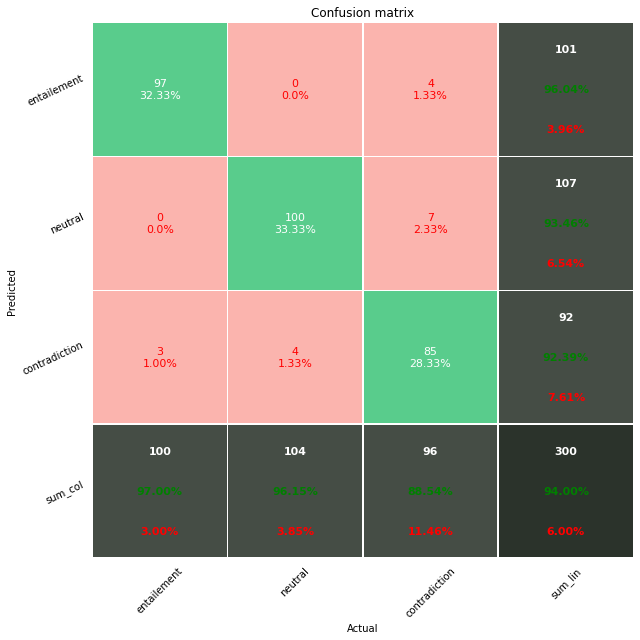

In [18]:
pp_matrix_from_data(Y_test, Y_predi, cmap='Pastel1',columns=['entailement','neutral','contradiction'],figsize=[6,6])

In [19]:
print(classification_report(Y_test, Y_predi))

              precision    recall  f1-score   support

           0       0.96      0.97      0.97       100
           1       0.93      0.96      0.95       104
           2       0.92      0.89      0.90        96

    accuracy                           0.94       300
   macro avg       0.94      0.94      0.94       300
weighted avg       0.94      0.94      0.94       300

